# Systematic Literature Review DX in Shipping - Citation and Co-citation analysis

Note: We can only do thematic analysis on title, since for the abstract we have inverted abstract and we are not capable of properly rebulding it

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain  # Correct import
# import json
# import numpy as np
# from collections import Counter

# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS
# from spacy.tokens import DocBin

# from gensim import corpora
# from gensim.models import LdaModel
# from sklearn.feature_extraction.text import TfidfVectorizer

# from transformers import BertTokenizer, BertModel
# import torch
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA

## Read the DB in

In [3]:
# Read in the file
#lit = pd.read_csv('C:/projects/dx_in_shipping/openalex_data_final.csv')
lit = pd.read_csv('./openalex_data.csv',low_memory=False)

In [4]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
substring = 'referenced_works'
# List all column names containing the substring using list comprehension
matching_columns = [k for k in lit.columns if substring in k]
matching_columns.remove('referenced_works_count')
#print(matching_columns)
#print(lit['referenced_works_0'])
#print(lit['id'])

In [5]:
# Let's build the graph of co-citations
node_ids = lit['id'].tolist()
G = nx.Graph()

for index, row in lit.iterrows():
    if not pd.isnull(row['id']):
        for c in matching_columns:
            if not pd.isnull(row[c]):
                # we only want to focus on co-citations when it comes to the graph
                if (row[c] in node_ids):
                    G.add_edge(row['id'], row[c])

In [8]:
print(G.number_of_nodes())

1298


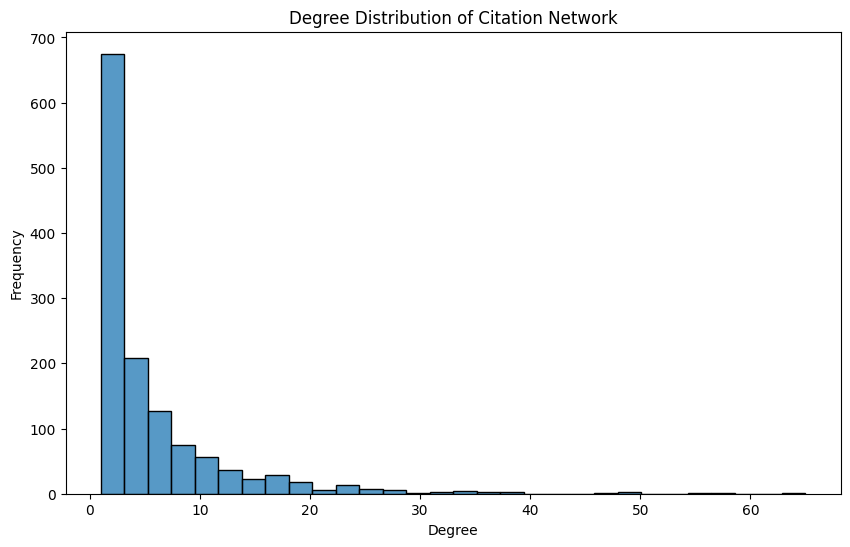

In [11]:
# Assuming G is your citation network graph
# Get a list of all degrees in the network
degrees = [deg for node, deg in G.degree()]

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the degree distribution as a histogram
sns.histplot(degrees, bins=30, kde=False, stat="count")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of Citation Network")
plt.show()

In [13]:
# Node degree (number of connections) can represent influence in the network
influential_papers = sorted(G.degree, key=lambda x: x[1], reverse=True)
print("Most influential papers:", influential_papers[:10])

Most influential papers: [('https://openalex.org/W3041382323', 65), ('https://openalex.org/W4399283331', 58), ('https://openalex.org/W2978644098', 55), ('https://openalex.org/W2964482263', 50), ('https://openalex.org/W4400493457', 48), ('https://openalex.org/W4308036928', 46), ('https://openalex.org/W2944924828', 39), ('https://openalex.org/W2917580293', 39), ('https://openalex.org/W4205557186', 38), ('https://openalex.org/W4225993858', 36)]


In [99]:
# Calculate node degree for each node in the network
node_degrees = dict(G.degree())

# Convert node degrees to a DataFrame for easier manipulation
degree_df = pd.DataFrame(list(node_degrees.items()), columns=['node', 'degree'])

# Set percentage of top nodes to keep (e.g., top 10%)
top_percentage = 0.20
num_nodes_to_keep = int(len(degree_df) * top_percentage)

# Sort by degree in descending order and select the top nodes
top_nodes = degree_df.sort_values(by='degree', ascending=False).head(num_nodes_to_keep)['node']

# Create a subgraph with only the top connected nodes
G_top = G.subgraph(top_nodes)

# we want toc consider only the largest connected component
connected_components = list(nx.connected_components(G_top))

# Step 2: Get the largest connected component (max by length)
largest_component = max(connected_components, key=len)

# Step 3: Create a subgraph of the largest connected component
G_lcc = G_top.subgraph(largest_component).copy()

print(G.number_of_nodes())
print(G_top.number_of_nodes())
print(G_lcc.number_of_nodes())


1298
259
257


In [77]:
top_nodes

188     https://openalex.org/W3041382323
1062    https://openalex.org/W4399283331
125     https://openalex.org/W2978644098
24      https://openalex.org/W2964482263
1036    https://openalex.org/W4400493457
                      ...               
650     https://openalex.org/W4400650555
857     https://openalex.org/W4200204151
635     https://openalex.org/W2002507421
862     https://openalex.org/W4387321456
565     https://openalex.org/W4396227246
Name: node, Length: 519, dtype: object

In [101]:
# Let's create communities

# Step 1: Apply Louvain method for community detection
partition = community_louvain.best_partition(G_lcc)

# Step 2: Visualize the graph with community colors
values = [partition.get(node) for node in G_lcc.nodes()]

# Step 4: Create a force-directed layout
pos = nx.spring_layout(G_lcc, k=0.15, iterations=100)

In [153]:
# Get unique communities and map them to colors
unique_communities = set(values)
community_colors = {community: plt.cm.rainbow(i / len(unique_communities)) for i, community in enumerate(unique_communities)}

# Step 4: Create a list of handles and labels for the legend
handles = []
labels = []
for community, color in community_colors.items():
    # Create a patch for the legend with each community's color
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(f"Community {community}")

# Step 4: Display community-color mapping
print("Community to Color Mapping:")
for community, color in community_colors.items():
    print(f"Community {community}: {color}")

Community to Color Mapping:
Community 0: (0.5, 0.0, 1.0, 1.0)
Community 1: (0.24901960784313726, 0.38410574917192586, 0.9806347704689777, 1.0)
Community 2: (0.0019607843137254832, 0.7092813076058535, 0.9232891061054894, 1.0)
Community 3: (0.2529411764705882, 0.9256376597815562, 0.8301840308155507, 1.0)
Community 4: (0.503921568627451, 0.9999810273487268, 0.7049255469061472, 1.0)
Community 5: (0.7549019607843137, 0.9209055179449537, 0.5523649729605058, 1.0)
Community 6: (1.0, 0.7005430375932911, 0.37841105004231035, 1.0)
Community 7: (1.0, 0.37270199199091436, 0.18980109344182594, 1.0)


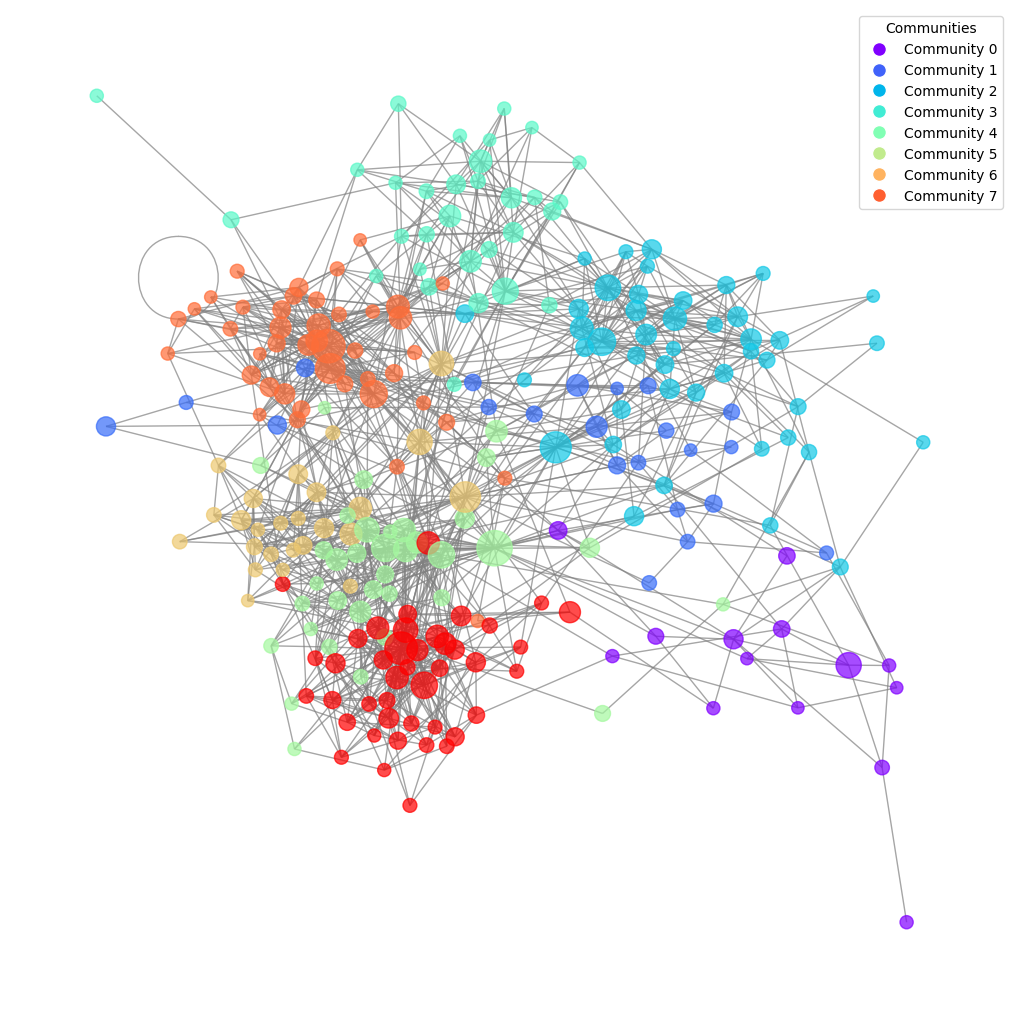

In [155]:
# Visualize the co-citation network

# Scale node sizes based on their degree in the original graph (before filtering)
node_sizes = [node_degrees[node] * 10 for node in G_lcc.nodes()]  # Multiply by 10 for visibility

plt.figure(figsize=(10, 10))  # Optional: Adjust figure size
nx.draw(G_lcc, pos, with_labels=False, node_size=node_sizes, node_color=values, cmap=plt.cm.rainbow, font_size=10, font_weight='bold', edge_color='gray', alpha=0.7)
# Add legend
plt.legend(handles=handles, labels=labels, title="Communities", loc="best", fontsize=10)
plt.show()

In [131]:
partition # this is a dictionary: the key is the article openalex id, and the value is the partition.

# we now collect the corresponding titles and link titles to partitions

partition_titles = {}
for k, v in partition.items():
    lit_f = lit[lit['id'] == k]
    if (len(lit_f)> 0):
        if v not in partition_titles:
            partition_titles[v] = [lit_f['title'].iloc[0]]
        else:
            partition_titles[v].append(lit_f['title'].iloc[0])
    else:
        print('not found')

['Spatial Modeling of Maritime Risk Using Machine Learning', 'Trends of digitalization, intelligence and greening of global shipping industry based on CiteSpace Knowledge Graph', 'Intelligent ship collision avoidance in maritime field: A bibliometric and systematic review', 'Research on ship safety risk early warning model integrating transfer learning and multi-modal learning', 'A machine learning approach for monitoring ship safety in extreme weather events', 'A concept of critical safety area applicable for an obstacle-avoidance process for manned and autonomous ships', 'A systematic analysis for maritime accidents causation in Chinese coastal waters using machine learning approaches', 'Analysis of factors affecting the severity of marine accidents using a data-driven Bayesian network', 'Development of an Interpretable Maritime Accident Prediction System Using Machine Learning Techniques', 'A human-centred review on maritime autonomous surfaces ships: impacts, responses, and future 

In [147]:
# Next we use chatgpt to summarize the titles in each partition as one topic
print(partition_titles[7])

['Blockchain technology investment strategy for shipping companies under competition', 'How TradeLens Delivers Business Value With Blockchain Technology', 'Blockchain-Powered Incentive System for JIT Arrival Operations and Decarbonization in Maritime Shipping', 'Blockchain adoption strategy of two-sided shipping platforms connecting forwarder and liner company', 'Blockchain implementation in the maritime industry: critical success factors and strategy formulation', 'Blockchain technology for port logistics capability: Exclusive or sharing', 'Blockchain Technology and Sustainability in Supply Chains and a Closer Look at Different Industries: A Mixed Method Approach', 'Blockchain technology in maritime supply chains: applications, architecture and challenges', 'A Review of Blockchain Technology Implementation in Shipping Industry', 'Analysing the intention to use blockchain technology in payment transactions of Turkish maritime industry', 'Consortium blockchain in Shipping: Impacts on in

## Next we use chatgpt to summarize the titles in each partition as one topic

### partition 0
The common theme across the research papers you provided is optimization and prediction of fuel consumption,
energy efficiency, and environmental impact in the maritime industry,
with a focus on machine learning, big data, and modeling techniques.

### partition 1
The common theme across these research papers is maritime safety, risk management, and the application of machine learning techniques to predict, analyze, and mitigate accidents and hazards in maritime operations. It also explores the intersection of autonomous ships, human factors, and intelligent systems in improving maritime safety.

### partition 2
The common theme across these research papers is machine learning, artificial intelligence, and big data applications in the maritime domain, with a focus on predictive analytics, vessel trajectory prediction, fuel consumption estimation, traffic management, cybersecurity, and autonomous ship operations.

### partition 3
The common theme across these research papers is the integration of Internet of Things (IoT), mobile edge computing, communication networks, and security within the maritime industry, with a particular focus on autonomous ships, data offloading, latency minimization, and communication technologies for maritime transportation systems.

### partition 4
The common theme across these research papers is the digital transformation and technological advancements within the maritime sector, particularly in relation to maritime logistics, container shipping, port operations, and the broader shipping supply chain. These studies explore the integration of digital twins, Industry 4.0 technologies, big data, IoT, machine learning, and artificial intelligence in improving efficiency, sustainability, and safety in maritime operations.

### partition 5
The common theme across these research papers revolves around the development and optimization of smart ports, focusing on the integration of Industry 4.0 technologies such as IoT, AI, big data, and blockchain. These studies emphasize how digitalization, automation, and energy efficiency are transforming port operations to make them more sustainable, efficient, and resilient in the face of global challenges. The research also explores the cybersecurity risks and sustainability efforts associated with green ports and smart infrastructure.

### partition 6
The common theme across these research papers is focused on maritime cybersecurity, with an emphasis on cyber risks associated with the digital transformation of the maritime industry, particularly as it pertains to the rise of autonomous vessels, smart shipping technologies, and the IoT-enabled maritime environment. These studies explore the vulnerabilities and cybersecurity challenges in both ports and ships, proposing various cyber risk assessments, threat modeling, and countermeasures to address emerging cyber threats. The papers also examine regulatory frameworks, cyber resilience training, and the impact of digitalization on ship systems, highlighting the need for proactive cybersecurity management.

### partition 7
The focus of these papers is on the adoption and application of blockchain technology in the maritime industry, specifically in areas like shipping, supply chains, and port management. The studies explore how blockchain can enhance efficiency, transparency, and sustainability within maritime logistics, including smart contracts, traceability, and decarbonization efforts. Key topics include investment strategies, barriers to adoption, collaborative platforms, and the impact of blockchain on shipping operations. These studies also examine technical sustainability, policy implications, and the business value of integrating blockchain in maritime logistics, highlighting the challenges and future potential of this transformative technology.

## Thematic analysis

In [38]:
# Load spaCy's English tokenizer
nlp = spacy.load('en_core_web_sm')

# Preprocess a column (e.g., 'abstract' or 'title') in the dataset
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in STOP_WORDS]
    return " ".join(tokens)

In [39]:
# Apply preprocessing to the relevant column (e.g., 'title' and 'abstract')
lit['cleaned_title'] = lit['title'].apply(preprocess_text)  # or 'title', depending on your focus

In [40]:
# Load pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and get embeddings for each document
inputs = tokenizer(lit['cleaned_title'].tolist(), padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Averaging the token embeddings

In [41]:
print(len(embeddings[0]))

768


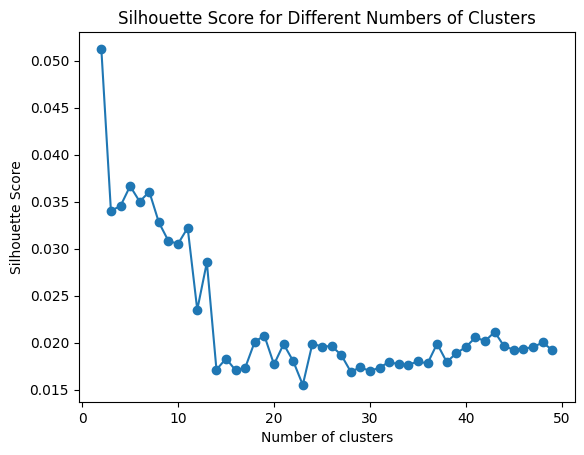

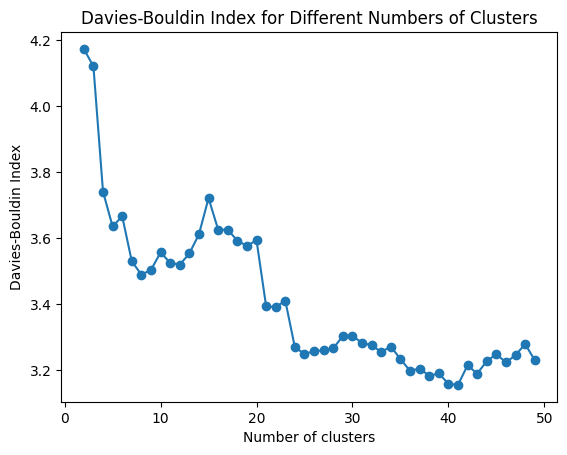

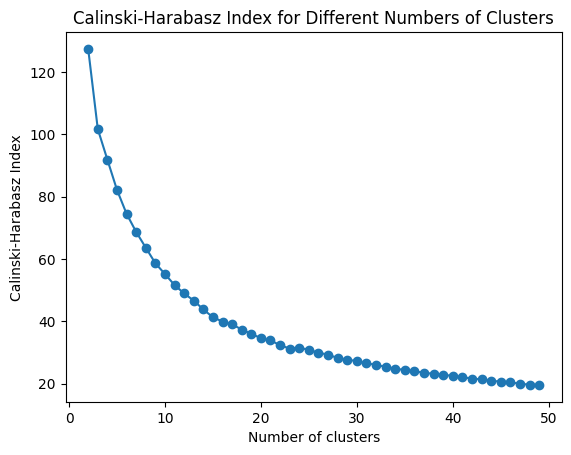

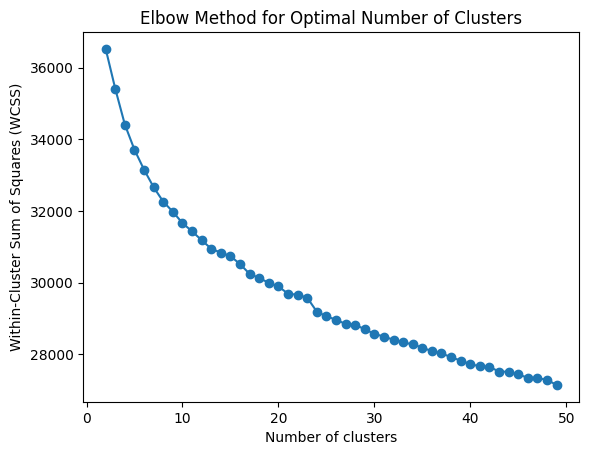

In [42]:
# Try different numbers of clusters

max_n_clusters = 50

from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, max_n_clusters):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(range(2, max_n_clusters), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

from sklearn.metrics import davies_bouldin_score
db_scores = []
for k in range(2, max_n_clusters):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(embeddings)
    score = davies_bouldin_score(embeddings, labels)
    db_scores.append(score)

# Plot Davies-Bouldin scores
plt.plot(range(2, max_n_clusters), db_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.show()

from sklearn.metrics import calinski_harabasz_score
# List to store Calinski-Harabasz scores for different numbers of clusters
ch_scores = []
# Define range for number of clusters
for k in range(2, max_n_clusters):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(embeddings)
    score = calinski_harabasz_score(embeddings, labels)
    ch_scores.append(score)

# Plot Calinski-Harabasz scores
plt.plot(range(2, max_n_clusters), ch_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Different Numbers of Clusters')
plt.show()

# Calculate WCSS for each number of clusters in range
wcss = []
for k in range(2, max_n_clusters):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)  # WCSS for each cluster count

# Plot WCSS for each cluster count to visualize the elbow
plt.plot(range(2, max_n_clusters), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [92]:
# Detect Topics

# Apply KMeans clustering to the embeddings
kmeans = KMeans(n_clusters=8)
labels = kmeans.fit_predict(embeddings)

# Add the predicted topics to the dataframe
lit['topic'] = labels

# Get cluster centroids from the KMeans model
from sklearn.metrics import pairwise_distances
centroids = kmeans.cluster_centers_

# For each cluster, find the documents closest to the centroid
num_representatives = 10  # Number of representative documents per topic
for i in range(kmeans.n_clusters):
    # Get the indices of documents in the current cluster
    cluster_docs_idx = np.where(labels == i)[0]
    
    # Calculate distances to the centroid for documents in the cluster
    distances = pairwise_distances(embeddings[cluster_docs_idx], centroids[i].reshape(1, -1))
    
    # Sort documents by proximity to centroid and select top N closest
    closest_docs_idx = cluster_docs_idx[distances.flatten().argsort()[:num_representatives]]
    
    # Display the closest document titles for interpretation
    print(f"\nTopic {i + 1}:")
    for idx in closest_docs_idx:
        print(f"  - {lit['title'].iloc[idx]}")

ValueError: Length of values (2290) does not match length of index (2326)

# I have then given the topic documents to GPT asking to summarize each topic in one description. This is the result:

### Topic 1: Machine Learning in Maritime Prediction and Risk Assessment

This topic centers on applying machine learning techniques for predictive analytics and risk assessment in the maritime domain. The studies involve various predictive models, including those for traffic management, collision avoidance, speed prediction in challenging conditions, and significant wave forecasting. The emphasis is on leveraging data-driven methods, such as deep learning and Bayesian networks, to anticipate and manage maritime risks and optimize traffic flow.

### Topic 2: Maritime Data Fusion, Abnormal Behavior Detection, and Communication Enhancement

Research in this area focuses on the use of data fusion from multiple sources for vessel trajectory prediction and abnormal behavior detection, often employing machine learning methods like Bayesian and Kalman-based approaches. Topics also include improvements in maritime communication through tracking and beamforming, as well as AI-driven detection in complex environments (e.g., radar clutter). These studies highlight real-time monitoring and proactive responses to ensure safer, more efficient maritime logistics.

### Topic 3: Digital Transformation and Efficiency in Maritime Operations

This topic discusses the role of digital technologies in optimizing maritime operations, with a particular focus on efficiency, risk mitigation, and sustainable practices. Case studies on container shipping and port operations emphasize digital transformation's impact on operations management, including analytics, smart technologies, and green initiatives. It reflects an industry shift towards analytics-enabled, environmentally sustainable practices to improve service delivery and operational performance.

### Topic 4: Blockchain Applications for Maritime Administration and Operations

The studies here explore blockchain technology’s integration into maritime management, including applications for delivery management, smart contracts, secure data exchange, and incentive structures in IoT environments. Blockchain’s use in ensuring trust and transparency in maritime transactions and operations, such as with MASS (Maritime Autonomous Surface Ships) and shipping consortia, underscores its potential to revolutionize traditional maritime administration and logistics.

### Topic 5: Machine Learning for Operational and Risk Prediction in Maritime Transport

This topic applies machine learning models to various operational predictions in maritime transport, such as fuel consumption, ship arrival times, and accident risk. Case studies demonstrate machine learning's practicality in providing accurate predictions under real-world conditions, enhancing operational efficiency, and improving safety through proactive risk management in shipping and port logistics.

### Topic 6: Autonomous Navigation and Safety in Complex Maritime Environments

Research in this area is concentrated on the development of autonomous navigation systems and safety enhancement through advanced technologies. This includes applications of deep learning for object detection, route planning, personnel monitoring, and fault detection. The focus is on utilizing big data and AI to support autonomous and efficient maritime operations, with a strong emphasis on safety in diverse and challenging maritime environments.

### Topic 7: Sustainable and Smart Shipping in Maritime Logistics

This topic examines the intersection of sustainability, smart technology, and logistics within maritime operations. Studies address innovative approaches in ship design, the role of digitalization, and human oversight in autonomous shipping. Research also explores optimization across the container shipping supply chain and identifies priority areas for smart shipping development, highlighting a shift towards sustainable, technology-driven maritime practices.

## Topic 8: Spatial Analysis and Environmental Risk in Maritime Safety

This topic involves the use of spatial and spatiotemporal analysis to study maritime accidents, environmental risks, and large-scale planning for offshore developments. Machine learning and remote sensing technologies enable detailed analyses of spatial patterns and accident risks over long periods. The studies underscore the importance of data-driven insights for predicting and mitigating environmental and operational risks in global and regional maritime settings.

## Keyword analysis in abstract and title

In [45]:
# need to read lit again to keep abstract this time

# Read in the file
#lit = pd.read_csv('C:/projects/dx_in_shipping/openalex_data_final.csv')
lit = pd.read_csv('./openalex_data.csv',low_memory=False)

In [90]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
substring = 'abstract_inverted_index'
# List all column names containing the substring using list comprehension
matching_columns = [k for k in lit.columns if substring in k]
matching_columns.append('title')
#print(matching_columns)
#lit['title']

In [47]:
lit = lit[matching_columns]

In [48]:
# prepare a function to extract keyword from column name

def extract_keyword(row, colnames):
    words = []
    for c in colnames:
        if pd.notnull(row[c]):
            csplit = c.split('_')
            if len(csplit) > 3:
                words.append(csplit[3])
    return ' '.join(words)

In [49]:
lit['full_abstract_words'] = lit.apply(lambda row: extract_keyword(row,matching_columns), axis=1)

In [50]:
lit = lit[['title', 'full_abstract_words']]

In [51]:
lit.loc[:, 'full_text'] = lit.apply(lambda row: f"{row['title']} {row['full_abstract_words']}", axis=1)

In [52]:
lit = lit [['full_text']]

In [53]:
# clean full_text

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Function to clean and preprocess text
def preprocess_text(text):
    doc = nlp(text)  # Process text with spaCy
    clean_words = [
        token.lemma_.lower() for token in doc  # Lemmatize and lowercase
        if not token.is_stop  # Remove stopwords
        and not token.is_punct  # Remove punctuation
    ]
    return ' '.join(clean_words)

# Apply the cleaning function to both columns
lit.loc[:, 'cleaned_text'] = lit['full_text'].apply(preprocess_text)

In [54]:
lit['cleaned_text']

0       predictive analysis maritime congestion dynami...
1       verifai framework functional verification ai b...
2       emerge trend signal processing machine learnin...
3       effectiveness problem base learning pbl mariti...
4       enhance leafy greens production nutrient film ...
                              ...                        
2321    novel bias tsp algorithm maritime patrol marit...
2322    ship collision avoidance base vulnerability as...
2323    pmbm filtering fusion target provide exterocep...
2324    research thrust allocation power positioning s...
2325    scan issue maritime maritime global ship impro...
Name: cleaned_text, Length: 2326, dtype: object

In [78]:
# We now perform key extraction in different ways

# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Use TfidfVectorizer to extract keywords
vectorizer = TfidfVectorizer(max_df=0.8, min_df = 2, stop_words='english', max_features=1000)  # Adjust max_df and max_features as needed
tfidf_matrix = vectorizer.fit_transform(lit['cleaned_text'])
tfidf_feature_names = vectorizer.get_feature_names_out()

# Show top N keywords per document based on TF-IDF score
top_n = 10  # Adjust the number of keywords you want
top_keywords = []

# For each document, get the top N keywords based on TF-IDF scores
for row in tfidf_matrix:
    # Zip the TF-IDF scores with feature names, and filter only terms with scores > 0 for the document
    sorted_items = sorted([(score, feature) for score, feature in zip(row.toarray().flatten(), tfidf_feature_names) if score > 0], reverse=True)
    keywords = [item[1] for item in sorted_items[:top_n]]
    top_keywords.append(keywords)

# Add keywords as a new column in the dataframe
lit['top_keywords'] = top_keywords
lit.head(5)

,full_text,cleaned_text,top_keywords
0,Predictive Analysis of Maritime Congestion Usi...,predictive analysis maritime congestion dynami...,"[prediction, analysis, feature, traffic, dynam..."
1,VerifAI: Framework for Functional Verification...,verifai framework functional verification ai b...,"[functional, ai, systems, domain, framework, b..."
2,Emerging trends in signal processing and machi...,emerge trend signal processing machine learnin...,"[special, signal, trend, processing, emerge, n..."
3,Effectiveness of Problem-based Learning (PBL) ...,effectiveness problem base learning pbl mariti...,"[learning, effectiveness, problem, base, marit..."
4,Enhancing Leafy Greens’ Production: Nutrient F...,enhance leafy greens production nutrient film ...,"[urban, production, food, container, automatio..."


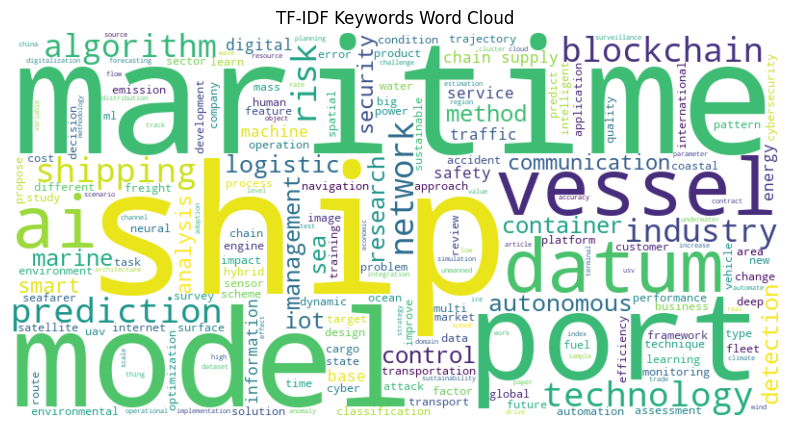

{'context', 'advantage', 'trend', 'based', 'highly', 'drone', 'aerial', 'effective', 'complex', 'ensure', 'optimization', 'ground', 'improve', 'port', 'avoid', 'resolution', 'company', 'green', 'line', 'recently', 'things', 'university', 'light', 'cooperative', 'prevent', 'surveillance', 'exchange', 'forecast', 'possibility', 'indicate', 'underwater', 'path', 'enterprise', 'currently', 'search', 'financial', 'legal', 'change', 'covid', 'express', 'stability', 'damage', 'consider', 'noise', 'year', 'engineering', 'relation', 'trajectory', 'social', 'building', 'account', 'world', 'confirm', 'international', 'essential', 'operation', 'field', 'vector', 'emission', 'free', 'explain', 'choice', 'conduct', 'aspect', 'transformation', 'respectively', 'introduce', 'computing', 'discussion', 'challenge', 'evaluate', 'train', 'logistics', 'allow', 'role', 'navigation', 'terminal', 'especially', 'conventional', 'security', 'www', 'practical', 'power', 'access', 'maximum', 'select', 'compute', 'n

In [109]:
from wordcloud import WordCloud

# Combine all keywords into a single list for each method (TF-IDF and BERT)
tfidf_keywords = [word for keywords in lit['top_keywords'] for word in keywords]

# Convert lists to a single string for word cloud generation
tfidf_keywords_text = " ".join(tfidf_keywords)

# Generate and plot the TF-IDF Word Cloud
wordcloud_tfidf = WordCloud(width=800, height=400, background_color="white").generate(tfidf_keywords_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tfidf, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Keywords Word Cloud")
plt.show()

# let's also get the unique keywords so we can check which to exclude for the next step
kw_set = set(tfidf_keywords)
print(kw_set)

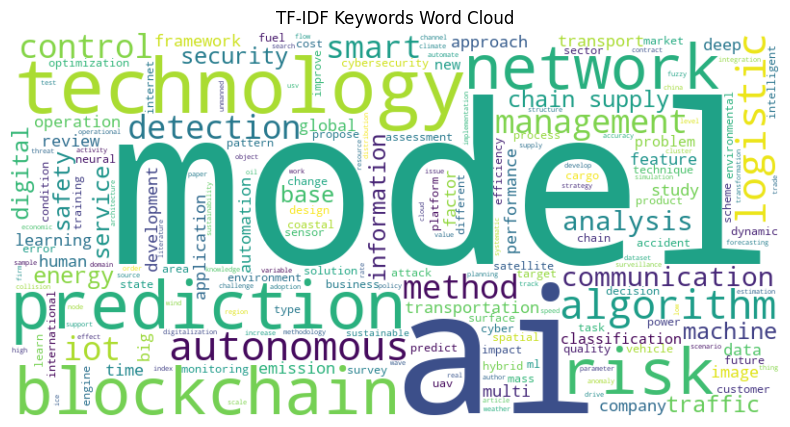

In [111]:
# Cloud of words removing strong ship-related words

# the following words have been detected from gpt 4
remove_words = [
'port',
'underwater',
'trajectory',
'hull',
'seafarer',
'navigation',
'terminal',
'vessel',
'waterway',
'marine',
'shipping',
'shoreline',
'offshore',
'route',
'onboard',
'usv (unmanned surface vehicle)',
'seaport',
'buoy',
'maritime',
'ship',
'mml (Maritime Mobile Service Identity)',
'ocean',
'fleet',
'inland',
'buoy',
'datum',
'container',
 'industry', 'marina', 'sea', 'research', 'water', 'freight'
]
#remove_words = ['maritime', 'ship', 'vessel', 'port', 'datum', 'container', 'shipping', 'industry', 'marina', 'sea', 'research', 'water', 'freight']

# Combine all keywords into a single list for each method (TF-IDF and BERT)
tfidf_keywords = [word for keywords in lit['top_keywords'] for word in keywords if word not in remove_words]

# Convert lists to a single string for word cloud generation
tfidf_keywords_text = " ".join(tfidf_keywords)

# Generate and plot the TF-IDF Word Cloud
wordcloud_tfidf = WordCloud(width=800, height=400, background_color="white").generate(tfidf_keywords_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tfidf, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Keywords Word Cloud")
plt.show()